In [1]:
import os, glob, re, random, gzip, json, pysam
from collections import Counter, defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Paternal reads proportion

In [2]:
names = ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"]
cs = ["Paternal", "Maternal", "Ambiguous", "Other", "Unknown"]
data = dict()

for name in names:
    cells = pd.read_csv("data/%s.qc_pass.tsv" % name, sep="\t")["Cell"]
    rows = []
    for cell in cells:
        run = cell.split(".")[0]
        path = "../../1_NanoStrandSeq/results/mapping/mark_parental/%s/%s.log" % (run, cell)
        if not os.path.exists(path):
            path = "../../2_StrandSeq/results/mapping/mark_parental/%s/%s.log" % (run, cell)
        d = dict()
        with open(path) as f:
            for line in f:
                if line.startswith("[W::hts_idx_load3]"):
                    continue
                k, v = line.strip("\n").split()[:2]
                v = int(v)
                k = k[:-1]
                d[k] = v
        row = [cell, d["Total"], d["Paternal"], d["Maternal"], d["Ambiguous"], d["Other"]]
        rows.append(row)
    dat = pd.DataFrame(rows)
    dat.columns = ["Cell", "Total", "Paternal", "Maternal", "Ambiguous", "Other"]
    dat["Unknown"] = dat["Total"] - dat["Paternal"] - dat["Maternal"] - dat["Ambiguous"] - dat["Other"]
    
    for c in cs:
        dat["%s(%%)" % c] = dat[c] * 100 / dat["Total"]
    
    data[name] = dat

Strand-seq
OP-Strand-seq
NanoStrand-seq


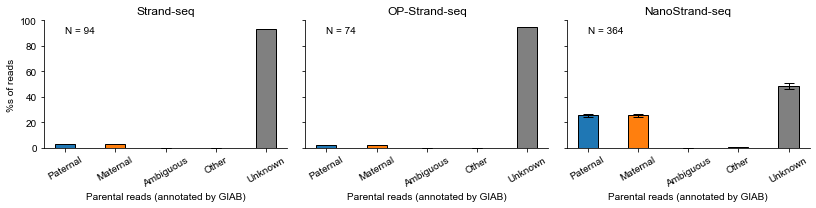

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(11.5, 3), sharex=True, sharey=True)

for i, name in enumerate(names):
    print(name)
    
    dat = data[name]
    
    plt.sca(axs[i])
    
    d = dat[dat.columns[-5:]]
    ys = d.mean(axis=0)
    yerr = d.std(axis=0)
    xs = np.arange(len(ys))
    
    plt.title(name)
    plt.bar(xs, ys, yerr=yerr, edgecolor="black", color=["C0", "C1", "grey", "grey", "grey"], width=0.4,
            error_kw={"capsize": 5, "lw": 1})
    plt.text(0, 90, "N = %d" % len(dat))
    plt.xticks(xs, cs, rotation=30)
    plt.ylim(0, 100)
    if i == 0:
        plt.ylabel("%s of reads")
    plt.xlabel("Parental reads (annotated by GIAB)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("figures/parental_of_reads.comparison.pdf", dpi=300)

## Mouse

In [4]:
names = ["NanoStrand-seq.MM"]
cs = ["Paternal", "Maternal", "Ambiguous", "Other", "Unknown"]
data = dict()

for name in names:
    cells = pd.read_csv("data/%s.qc_pass.tsv" % name, sep="\t")["Cell"]
    rows = []
    for cell in cells:
        run = cell.split(".")[0]
        path = "../../1_NanoStrandSeq/results/mapping/mark_parental/%s/%s.log" % (run, cell)
        if not os.path.exists(path):
            path = "../../2_StrandSeq/results/mapping/mark_parental/%s/%s.log" % (run, cell)
        d = dict()
        with open(path) as f:
            for line in f:
                if line.startswith("[W::hts_idx_load3]"):
                    continue
                k, v = line.strip("\n").split()[:2]
                v = int(v)
                k = k[:-1]
                d[k] = v
        row = [cell, d["Total"], d["Paternal"], d["Maternal"], d["Ambiguous"], d["Other"]]
        rows.append(row)
    dat = pd.DataFrame(rows)
    dat.columns = ["Cell", "Total", "Paternal", "Maternal", "Ambiguous", "Other"]
    dat["Unknown"] = dat["Total"] - dat["Paternal"] - dat["Maternal"] - dat["Ambiguous"] - dat["Other"]
    
    for c in cs:
        dat["%s(%%)" % c] = dat[c] * 100 / dat["Total"]
    
    data[name] = dat

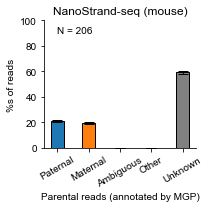

In [5]:
plt.figure(figsize=(3, 3))

dat = data["NanoStrand-seq.MM"]


d = dat[dat.columns[-5:]]
ys = d.mean(axis=0)
yerr = d.std(axis=0)
xs = np.arange(len(ys))

plt.title("NanoStrand-seq (mouse)")
plt.bar(xs, ys, yerr=yerr, edgecolor="black", color=["C0", "C1", "grey", "grey", "grey"], width=0.4,
        error_kw={"capsize": 5, "lw": 1})
plt.text(0, 90, "N = %d" % len(dat))
plt.xticks(xs, cs, rotation=30)
plt.ylim(0, 100)
plt.ylabel("%s of reads")
plt.xlabel("Parental reads (annotated by MGP)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig("figures/parental_of_reads.mouse.pdf", dpi=300)

# Heatmap of crick proportion

In [2]:
name = "NanoStrand-seq"
chroms = ["chr%d" % c for c in range(1, 23)] + ["chrX", "chrY"]
dat = pd.read_csv("results/%s.qc_pass.tsv" % name, sep="\t")
dat = dat.sort_values(by="Background").head(50)

In [3]:
rows = []
for cell in dat["Cell"]:
    path = "../../1_NanoStrandSeq/results/counts/stat_bin_reads/%s/%s.tsv" % (cell.split(".")[0], cell)
    df = pd.read_csv(path, sep="\t")
    row = []
    for chrom in chroms:
        df1 = df[df["Chrom"] == chrom]
        c1, c2 = df1["Crick"].sum(), df1["Watson"].sum()
        p = np.divide(c1, (c1 + c2))
        row.append(p)
    rows.append(row)
d = pd.DataFrame(rows, index=dat["Cell"], columns=chroms)

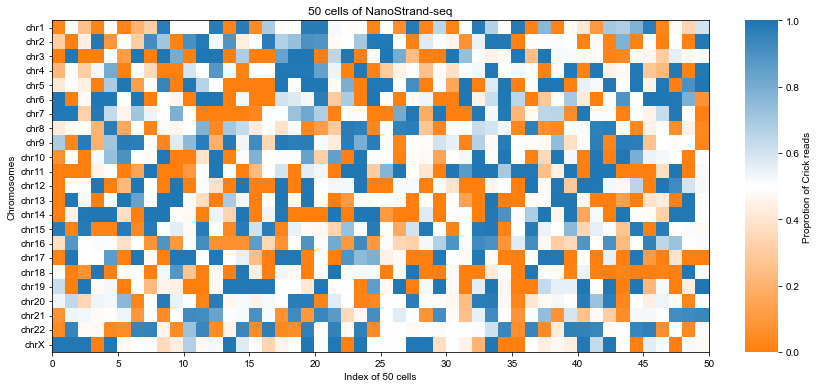

In [4]:
d = d[list(filter(lambda item: item != "chrY", d.columns))]
cmap = LinearSegmentedColormap.from_list('chaos', ["C1", "white", "C0"])

plt.figure(figsize=(11.5, 5.5))
plt.title("%d cells of %s" % (len(d), name))
sns.heatmap(d.T, cmap=cmap, vmin=0, vmax=1,
            cbar_kws={"label": "Proprotion of Crick reads", "fraction": 0.05, "aspect": 10, "panchor": (1, 1)})
xs = np.arange(0, 50 + 1, 5)
plt.xticks(xs, xs, rotation=0)
plt.gca().spines["top"].set_visible(True)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["left"].set_visible(True)
plt.gca().spines["right"].set_visible(True)
plt.xlabel("Index of 50 cells")
plt.ylabel("Chromosomes")
plt.tight_layout()
plt.savefig("figures/heatmap_of_crick_proportion.%s.pdf" % name, dpi=300)